In [ ]:
# packages needed

import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
# load data

working_directory = "./20degrees"

dir_name = os.chdir(working_directory) # get current working directory (could be changed to path where the files are stored)
rawdata = {}
for file in os.listdir(dir_name): 
    if ".csv" in file:
        rawdata[file] = pd.read_csv(file, sep=";")

In [3]:
# define functions needed

def ReshapeData(rawdata, norm="750"):
    """
    gets the data in the final shape we need it to work with by formatting and normalizing it
    """

    # define functions needed
    def FormatDataframe(df):
        """
        formats dataframe df to obtain the absorption values for each wavelength for each sample
        """
        columns_to_drop = ["No.", "Type", "Date/Time", "Note"]
        df_new = df.copy()                                       # create copy of the dataframe we're working with
        df_new = df_new.drop(columns_to_drop, axis=1)            # remove useless columns  
        df_new = df_new.rename(columns={"Name": "Wavelength"})   # rename first column as Wavelength
        df_new = df_new.set_index("Wavelength")                  # change index needed because currently, column containing wavelengths is the index
        df_new = df_new.transpose()                              # switch rows and columns
        df_new = df_new.rename(columns={"DualTag": "GFP"})   
        df_new = df_new[:-1]                                     # remove last row which is not relevant
        df_new = df_new.replace({',': '.'}, regex=True)          # replace all commas by points to be able to convert values into float
        df_new = df_new.astype(float)                            # convert values into float
        
        # change the index value from string to float
        indexes = list(df_new.index)                         # get list from all indexes
        new_indexes = {}                                     # create dict to store old and new indexes as key-value pairs
        for i in range(len(indexes)):                        # for each of the old indexes:
            new = indexes[i].replace(",", ".")               # replace the , by a . in the string
            new = float(new)                                 # then transform the string into a float
            new_indexes[indexes[i]] = new                    # finally add the new old index-new index pair to the dictionary
        df_new.rename(index=new_indexes, inplace=True)       # replace old indexes by new indexes 
        
        return df_new


    def Normalize(Abs, Spectrum, Sample, norm="750"):
        """
        normalization of the absorbtion spectra after the phycobillisome 
        absorption maximum and the absorption at 750 nm for the Spectrum
        of a given Sample

        type of normalization can be chosen:
            norm="750" (default): ormalization over 750 nm peak (quantity of cells)
            norm="PCA": normalization over 750 nm peak and phycobillin peak
            norm="nope": no normalization
        """
        Abs_750nm = Spectrum[Sample][750.0]                              # get absorbance at 750 nm for the sample
        Abs_phycobillisome = Spectrum[Sample].loc[600.0:650.0].max()     # get maximum of the phycobillisome peak (600-650 nm)
        
        if norm=="750":
            return (Abs - Abs_750nm) / (Abs_750nm)                          # normalization over 750 nm peak (quantity of cells)
        elif norm=="PCA":
            return (Abs - Abs_750nm) / (Abs_phycobillisome - Abs_750nm)     # normalization over 750 nm peak and phycobillin peak
        elif norm=="nope":
            return Abs                                                      # no normalization

    #####

    data = rawdata.copy()

    formatted_data = {}
    for filename in data:
        # formatting
        formatted_data[filename] = FormatDataframe(data[filename])
        # normalization
        for sample in formatted_data[filename]:
            formatted_data[filename]["new_col"] = formatted_data[filename][sample].apply(lambda row: Normalize(row, formatted_data[filename], sample, norm)) # applies the function Normalize to each row of the dataframe and stores it in new column
            formatted_data[filename] = formatted_data[filename].rename(columns={"new_col": f"{sample}_Normalized"}) 

    return formatted_data


def Ratio(Spectrum, Sample):
    """
    returns the ratio of the maximum of the phycobillisome peak (600-650 nm)
    and the maximum of the chlorophyll a peak (651-750 nm) for the Spectrum
    of a given Sample
    """
    Abs_phycobillisome = Spectrum[Sample].loc[600.0:650.0].max()  # get maximum of the phycobillisome peak (600-650 nm)
    Abs_chlorophyllA = Spectrum[Sample].loc[651.0:750.0].max()    # get maximum of the chlorophyll a peak (651-750 nm)
    
    # calculation of ratio PCA/ChlA according to J. Myers, J.-R. Graham, R. T. Wang Plant Physiology (1980)
    # the correction factors take into account the fact that the chlorophyll a and phycobillisome peaks are not fully separated
    ratio = (1.0162*Abs_phycobillisome-0.2612*Abs_chlorophyllA)/(1.0162*Abs_chlorophyllA-0.063*Abs_phycobillisome)

    return ratio 


def Plotting(df, filename, color=1):

    """
    plotting each column of a dataframe in the same plot
    
    df: dataframe to be plotted
    filename: name of the file the dataframe comes from
    color: default value of 1 colors the mutants in the same color and the complementants in the same color
            works only with normalized data
    """
    if color:
        df["WT_Normalized"].plot(color="black", label="WT")
        df["GFP_Normalized"].plot(color="grey", label="GFP")
        df["delta-rbp1 #2_Normalized"].plot(color="#d952e7", linestyle='dashed', label=r"$\Delta \it{rbp1}$ #2")
        df["delta-rbp1 #4_Normalized"].plot(color="#ff00d0", linestyle='dashed', label=r"$\Delta \it{rbp1}$ #4")
        df["delta-rbp1 #6_Normalized"].plot(color="#a11b65", linestyle='dashed', label=r"$\Delta \it{rbp1}$ #6")
        df["RBP1-GFP #4_Normalized"].plot(color="#0c8b30", linestyle='dotted', label="RBP1-GFP #4")
        df["RBP1-GFP #11_Normalized"].plot(color="#124c02", linestyle='dotted', label="RBP1-GFP #11")
        df["RBP1-GFP #12_Normalized"].plot(color="#5cb56f", linestyle='dotted', label="RBP1-GFP #12")
    else:
        for sample in df:
            df[sample].plot()                                     # for each column, plots the data
    
    # plot formatting                      
    plt.xlim(400,750)                                             # define limits of x axis to 400-750 nm
    plt.xlabel("Wavelength (nm)")                                 # label x-Axis as "Wavelength (nm)"
    plt.ylabel("Absorbance (AU)")                                 # label y-Axis as "Absorbance (AU)"
    plt.legend(fontsize="8", loc="upper center")                   # generate legend
    title = filename.split("spectrum ")[1].split("ColdShock")[0]  # extract info for title from filename (timepoint), the [] are because split returns a list of two strings   
    title = title[:1].upper() + title[1:]                         # make first letter of title uppercase
    plt.title(title)                                              # generate title     
    
    return plt


def Plotting2(Data, Sample, Normalized=1):
    """
    plots all spectra of all conditions (Data) of one Sample in one plot

    As a default, the data is normalized using the function Normalize, 
    set Normalized=0 to work with non-normalized data
    """
    for filename in Data:
        if Normalized: 
            Data[filename] = Data[filename].filter(regex='_Normalized', axis=1)   # only filters if the data was normalized
            legend = filename.split("spectrum ")[1].split("ColdShock")[0]
            legend = legend[:1].upper() + legend[1:]
            Data[filename][f"{Sample}"].plot(label=f"{legend}")
        else:
            legend = filename.split("spectrum ")[1].split("ColdShock")[0]
            legend = legend[:1].upper() + legend[1:]
            Data[filename][Sample].plot(label=f"{legend}")
    plt.xlim(400,750)                                       # define limits of x axis to 400-750 nm
    plt.xlabel("Wavelength (nm)")                           # label x-Axis as "Wavelength (nm)"
    plt.ylabel("Absorbance (AU)")                           # label y-Axis as "Absorbance (AU)"
    plt.legend(fontsize="8", loc="upper center")             # generate legend
    plt.title(Sample)                                       # generate title
    
    return plt


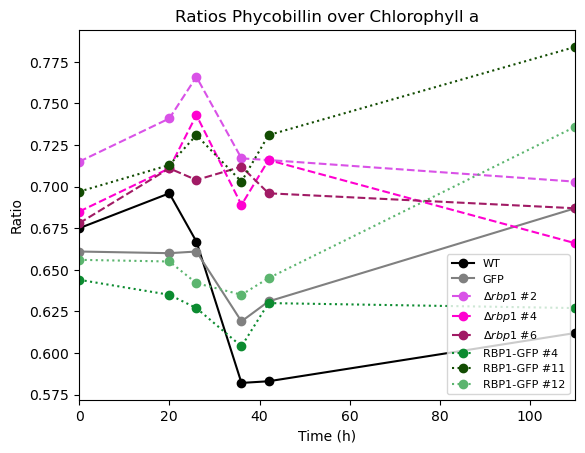

In [4]:
# Ratio Abs(phycobillisome) / Abs(chlorophyll a)

formatted_data = ReshapeData(rawdata, norm="750")

## create empty dict to store ratios into:
# the dict should have one entry for the timepoints 
# and one for each sample as the keys with a list 
# of the timepoints/ratios as the values
all_ratios = {} # empty dict
all_ratios["Time (h)"] = [] # empty list of timepoints
for filename in formatted_data:
    formatted_data[filename] = formatted_data[filename].filter(regex='_Normalized', axis=1) # only look at the normalized data
    all_ratios["Time (h)"].append(int(filename.split("spectrum")[1].split("h")[0]))         # fill list of timepoints using filenames, timepoints as ints for later plotting
    for sample in formatted_data[filename]:
        all_ratios[f"{sample}"] = []                                          # create empty list for the ratios of each sample

## compute the ratios and add them to the dict
for filename in formatted_data:
    for sample in formatted_data[filename]:
        all_ratios[f"{sample}"].append(round(Ratio(formatted_data[filename], sample), 3)) # rounding the ratios to 3 decimal places

## plot the ratios
df = pd.DataFrame(all_ratios) # convert the dict into a dataframe
df = df.set_index("Time (h)") # make the timepoints the indexes
# plot the ratios of each sample (done like this to achieve formatting of the labels)
df["WT_Normalized"].plot(color="black", label="WT", marker="o")
df["GFP_Normalized"].plot(color="grey", label="GFP", marker="o")
df["delta-rbp1 #2_Normalized"].plot(color="#d952e7", linestyle='dashed', label=r"$\Delta \it{rbp1}$ #2", marker="o")
df["delta-rbp1 #4_Normalized"].plot(color="#ff00d0", linestyle='dashed', label=r"$\Delta \it{rbp1}$ #4", marker="o")
df["delta-rbp1 #6_Normalized"].plot(color="#a11b65", linestyle='dashed', label=r"$\Delta \it{rbp1}$ #6", marker="o")
df["RBP1-GFP #4_Normalized"].plot(color="#0c8b30", linestyle='dotted', label="RBP1-GFP #4", marker="o")
df["RBP1-GFP #11_Normalized"].plot(color="#124c02", linestyle='dotted', label="RBP1-GFP #11", marker="o")
df["RBP1-GFP #12_Normalized"].plot(color="#5cb56f", linestyle='dotted', label="RBP1-GFP #12", marker="o")
# formatting of the plot
plt.ylabel("Ratio")
plt.legend(fontsize="8")
title = "Ratios Phycobillin over Chlorophyll a"
plt.title(title)
plt.xlim(min(all_ratios["Time (h)"]), max(all_ratios["Time (h)"]))
plt.savefig(f"{title}.jpg")
#plt.close()


In [5]:
# one plot per timepoint containing all samples

formatted_data = ReshapeData(rawdata, norm="750")

# plotting
for filename in formatted_data:
    plot = Plotting(formatted_data[filename], filename)
    plot.savefig(f"{filename.split("spectrum")[1].split(".")[0]}.jpg")
    plot.close()

In [6]:
# one plot per sample containing all timepoints

formatted_data = ReshapeData(rawdata, norm="750")

# plotting
for sample in list(formatted_data[filename].filter(regex="_Normalized")):
    plot = Plotting2(formatted_data, sample)
    plot.savefig(f"{sample}.jpg")
    plot.close()
    